In [1]:
!pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_path="/content/drive/MyDrive/data/41-50/Training"
test_path="/content/drive/MyDrive/data/41-50/Testing"
val_path="/content/drive/MyDrive/data/41-50/Validation"

In [5]:
IMAGE_SIZE = [224, 224]

In [6]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [7]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

In [8]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

In [9]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [10]:
train_x.shape,test_x.shape,val_x.shape

((1128, 224, 224, 3), (323, 224, 224, 3), (163, 224, 224, 3))

In [11]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')


Found 1128 images belonging to 4 classes.
Found 323 images belonging to 4 classes.
Found 163 images belonging to 4 classes.


In [14]:
training_set.class_indices

{'Calcification Benign': 0,
 'Calcification Malignant': 1,
 'Mass Benign': 2,
 'Mass Malignant': 3}

In [15]:
train_y=training_set.classes

In [16]:
test_y=test_set.classes

In [17]:
val_y=val_set.classes

In [18]:
train_y.shape,test_y.shape,val_y.shape

((1128,), (323,), (163,))

In [19]:
'''preprocessing layer to the front of resnet
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)'''

"preprocessing layer to the front of resnet\nresnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)"

In [20]:
import tensorflow as tf
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + [3])

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
prediction  = Dense(units=4, activation='softmax')(x)
model = Model(ResNet_model.input, outputs=prediction)


model.summary()

234561536/234545216 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [21]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

#Early stopping to avoid overfitting of model

In [23]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=50,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/50
36/36 [==============================] - 51s 753ms/step - loss: 1.1474 - accuracy: 0.5213 - val_loss: 9.5527 - val_accuracy: 0.5767
Epoch 2/50
36/36 [==============================] - 22s 607ms/step - loss: 0.9662 - accuracy: 0.5745 - val_loss: 8.2188 - val_accuracy: 0.5767
Epoch 3/50
36/36 [==============================] - 22s 605ms/step - loss: 0.9006 - accuracy: 0.5771 - val_loss: 5.8932 - val_accuracy: 0.5276
Epoch 4/50
36/36 [==============================] - 22s 603ms/step - loss: 0.8074 - accuracy: 0.6463 - val_loss: 5.4193 - val_accuracy: 0.4663
Epoch 5/50
36/36 [==============================] - 22s 603ms/step - loss: 0.6666 - accuracy: 0.7367 - val_loss: 3.5567 - val_accuracy: 0.4540
Epoch 6/50
36/36 [==============================] - 22s 603ms/step - loss: 0.5734 - accuracy: 0.7890 - val_loss: 6.7889 - val_accuracy: 0.4908
Epoch 7/50
36/36 [==============================] - 22s 603ms/step - loss: 0.4524 - accuracy: 0.8466 - val_loss: 5.2494 - val_accuracy: 0.3374

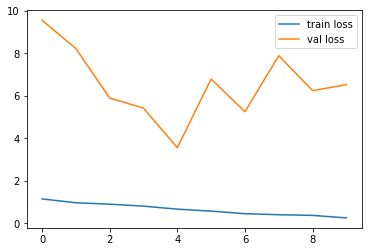

In [24]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('resnet-loss.png')
plt.show()

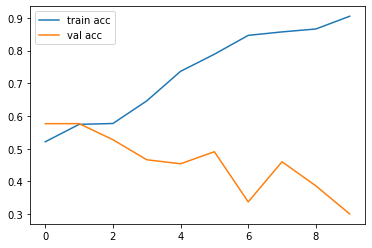

In [25]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('resnet-acc.png')
plt.show()

In [26]:
model.save("ResNet152V2-final.h5")